In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import scipy.io as sio
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


# Data Processing

In [2]:
# only for one stock
cleaned_close = sio.loadmat('../Pcleaned.mat')['P']
macd = pd.read_csv('../macd.csv').dropna()
rsi = pd.read_csv('../rsi.csv').dropna()
momentum = pd.read_csv('../momentum.csv').dropna()

In [3]:
cleaned_close_stock_1 = cleaned_close[:, 0].reshape(-1,4)
sell_indices = np.argmax(cleaned_close_stock_1, axis=1)
buy_indices = np.argmin(cleaned_close_stock_1, axis=1)
# buy=-1, hold=0, sell=1, 
labels = np.zeros(cleaned_close_stock_1.shape)
labels[np.arange(len(cleaned_close_stock_1)), sell_indices] = int(2)
labels[np.arange(len(cleaned_close_stock_1)), buy_indices] = int(1)
cleaned_close_stock_1_df = pd.DataFrame({'Close': cleaned_close[:, 0], 
                                         'Label': labels.flatten()})

In [4]:
def label_race(row):
    if row['Label'] == 2.0 :
        return 'Sell'
    elif row['Label'] == 0.0 :
        return 'Hold'
    elif row['Label'] == 1.0 :
        return 'Buy'

In [5]:
cleaned_close_stock_1_df['Action'] = cleaned_close_stock_1_df.apply(lambda row: 
                                                            label_race(row), axis=1)

In [6]:
cleaned_close_stock_1_df.head()

,Close,Label,Action
0,11.36,2.0,Sell
1,11.32,0.0,Hold
2,10.88,0.0,Hold
3,10.82,1.0,Buy
4,10.98,0.0,Hold


## Train Test Split

In [7]:
train_proportion = 0.9

In [8]:
ytrain_data_stock_1 = cleaned_close_stock_1_df[25:int(train_proportion*len(cleaned_close_stock_1_df))]['Label'].values
ytest_data_stock_1 = cleaned_close_stock_1_df[int(train_proportion*len(cleaned_close_stock_1_df)):-1]['Label'].values

xtrain_rsi = rsi[0:int(train_proportion*len(cleaned_close_stock_1_df))-25]['RelativeStrengthIndex'].values
xtest_rsi = rsi[int(train_proportion*len(cleaned_close_stock_1_df))-25:-1]['RelativeStrengthIndex'].values

xtrain_macd = macd[0:int(train_proportion*len(cleaned_close_stock_1_df))-25]['Close'].values
xtest_macd = macd[int(train_proportion*len(cleaned_close_stock_1_df))-25:-1]['Close'].values

xtrain_momentum = momentum[0:int(train_proportion*len(cleaned_close_stock_1_df))-25]['Close'].values
xtest_momentum = momentum[int(train_proportion*len(cleaned_close_stock_1_df))-25:-1]['Close'].values

In [9]:
ohe = OneHotEncoder(categories='auto')
ytrain_data_stock_1 = ytrain_data_stock_1.reshape(-1, 1)
ytrain_data_stock_1 = ohe.fit_transform(ytrain_data_stock_1).toarray()
ytest_data_stock_1 = ytest_data_stock_1.reshape(-1, 1)
ytest_data_stock_1 = ohe.fit_transform(ytest_data_stock_1).toarray()

In [10]:
X_train = np.array([xtrain_rsi, xtrain_macd, xtrain_momentum]).reshape(-1, 3)
X_test = np.array([xtest_rsi, xtest_macd, xtest_momentum]).reshape(-1, 3)

In [11]:
scaler_X_train = StandardScaler()
X_train = scaler_X_train.fit_transform(X_train)

scaler_X_test = StandardScaler()
X_test = scaler_X_test.fit_transform(X_test)

In [12]:
X_train.shape

(1479, 3)

# Neural Network

In [13]:
model = Sequential()
model.add(Dense(16, input_dim=3, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
history = model.fit(X_train, ytrain_data_stock_1, 
                    validation_data=(X_test,ytest_data_stock_1), epochs=100, batch_size=64)

Train on 1479 samples, validate on 167 samples
Epoch 1/100
1479/1479 [==============================] - 0s 318us/step - loss: 1.0648 - acc: 0.5003 - val_loss: 1.0550 - val_acc: 0.5090
Epoch 2/100
1479/1479 [==============================] - 0s 43us/step - loss: 1.0519 - acc: 0.5003 - val_loss: 1.0468 - val_acc: 0.5090
Epoch 3/100
1479/1479 [==============================] - 0s 45us/step - loss: 1.0467 - acc: 0.5003 - val_loss: 1.0419 - val_acc: 0.5090
Epoch 4/100
1479/1479 [==============================] - 0s 46us/step - loss: 1.0441 - acc: 0.5003 - val_loss: 1.0417 - val_acc: 0.5090
Epoch 5/100
1479/1479 [==============================] - 0s 46us/step - loss: 1.0436 - acc: 0.5003 - val_loss: 1.0392 - val_acc: 0.5090
Epoch 6/100
1479/1479 [==============================] - 0s 50us/step - loss: 1.0421 - acc: 0.5003 - val_loss: 1.0392 - val_acc: 0.5090
Epoch 7/100
1479/1479 [==============================] - 0s 60us/step - loss: 1.0422 - acc: 0.5003 - val_loss: 1.0388 - val_acc: 0.5090


# Prediction

In [16]:
y_pred = model.predict(X_test)
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
test = list()
for i in range(len(ytest_data_stock_1)):
    test.append(np.argmax(ytest_data_stock_1[i]))

In [17]:
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 50.898203592814376


In [18]:
confusion_matrix = np.zeros([3,3])

for i in range(len(pred)):
    confusion_matrix[int(test[i]), int(pred[i])] += 1

confusion_matrix_df = pd.DataFrame(confusion_matrix, columns=['Hold', 'Buy', 'Sell'],
                                  index=['Hold', 'Buy', 'Sell'])

In [19]:
confusion_matrix_df

,Hold,Buy,Sell
Hold,85.0,0.0,0.0
Buy,41.0,0.0,0.0
Sell,40.0,1.0,0.0


In [20]:
test.count(0), test.count(1), test.count(2)

(85, 41, 41)

In [21]:
pred.count(0), pred.count(1), pred.count(2)

(166, 1, 0)

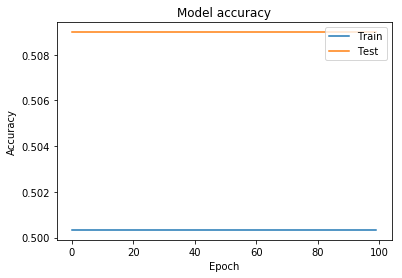

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

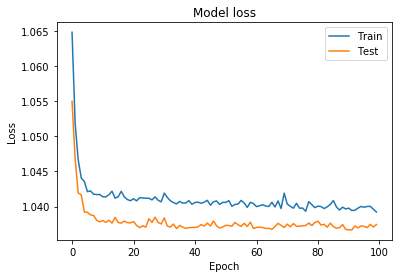

In [23]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper right') 
plt.show()

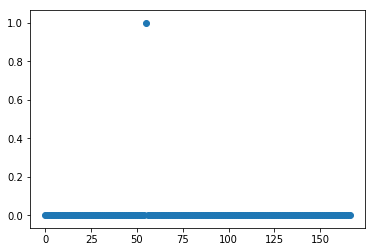

In [24]:
plt.scatter(np.arange(len(pred)), pred)

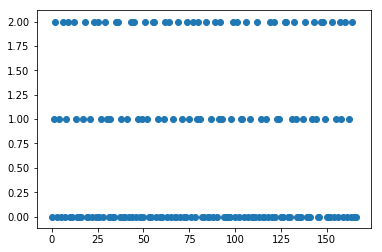

In [25]:
plt.scatter(np.arange(len(test)), test)